In [1]:
%matplotlib inline

In [2]:
from ankisync2 import Apkg
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
import os
import itertools
import math
import sqlite3
from contextlib import closing
from time import sleep

import pandas as pd
import scipy as sp
import numpy as np

In [3]:
class Helpers(object):
    def __init__(self):
        pass

    @staticmethod
    def clean_html_tags(markup):
        soup = BeautifulSoup(markup, 'html.parser')
        for br in soup.find_all('br'):
            br.replace_with('\n')
        return soup.get_text()

    @staticmethod
    def get_images(markup):
        out = []
        if markup:
            soup = BeautifulSoup(markup, 'html.parser')
            images = soup.findAll('img')
            for image in images:
                out.append(image['src'])
        return out

    @staticmethod
    def remove_cloze(markup):
        # txt = '<a href="blah"> Hello {{c1::world}} once {{c2::again::hint}} lol </a>'
        return re.sub('{{.*?::(.*?)(::.*?){0,}}}', '\\1', markup)

    @staticmethod
    def telescope_tags(taglist):
        out = []
        for tag in taglist:
            splt = tag.lower().split('::')
            for i in range(1, len(splt)):
                out.append('::'.join(splt[0:i]))
        return set(out)

    @staticmethod
    def jaccard_similarity(list1, list2):
        s1 = set(list1)
        s2 = set(list2)
        try:
            jaccard = float(len(s1.intersection(s2)) / len(s1.union(s2)))
        except ZeroDivisionError:
            jaccard = 0
        return jaccard
    
    @staticmethod
    def intersection_size(list1, list2):
        s1 = set(list1)
        s2 = set(list2)
        return len(s1.intersection(s2))
    
    @staticmethod
    def mirror_matrix(coo_mat):
        coo = coo_mat.copy()
        l = coo.shape[0]
        w = coo.shape[1]
        assert l == w, 'Matrix must be square'
        for i in tqdm(range(l), 'Mirroring matrix'):
            for j in range(l):
                ij = tmp[i, j]
                ji = tmp[j, i]
                if ij != ji:
                    if ij == 0:
                        coo[i,j] = ji
                    elif ji == 0:
                        coo[j,i] = ij
                    else:
                        raise ValueError(f'At i={i} and j={j} there are conflicting values of {ij} and {ji}.')
        return coo

In [4]:
class SQL(object):
    DELAY = 0.5  # Just for display purposes

    def __init__(self, path):
        self.path = path

    def init_sql(self):
        print(f'Creating new storage db at {self.path}')
        conn = sqlite3.connect(self.path)
        cursor = conn.cursor()
        for tbl in ['cards', 'tags', 'images', 'tag_image_sim',
                    'note_image_sim', 'note_tag_sim', 'note_text_sim', 'note_overall_sim',
                    'tag_sim', 'image_sim']:
            cursor.execute(f'DROP TABLE IF EXISTS {tbl}')

        cursor.execute('CREATE TABLE cards (card_id integer);')
        cursor.execute('CREATE TABLE tags (tag string);')
        cursor.execute('CREATE TABLE images (image string);')
        cursor.execute('CREATE INDEX cards_idx ON cards (card_id);')
        cursor.execute('CREATE INDEX tags_idx ON tags (tag);')
        cursor.execute('CREATE INDEX images_idx ON images (image);')

        cursor.execute('''
                       CREATE TABLE tag_image_sim
                       (tag string, 
                       image string,
                       value real,
                       
                       FOREIGN KEY (tag) REFERENCES tags (tag) ON DELETE CASCADE,
                       FOREIGN KEY (image) REFERENCES images (image) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX tag_image_sim_idx ON tag_image_sim (tag, image);')
        cursor.execute('''
                       CREATE TABLE note_image_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_image_sim_idx ON note_image_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE note_tag_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_tag_sim_idx ON note_tag_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE note_text_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_text_sim_idx ON note_text_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE note_overall_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_overall_sim_idx ON note_overall_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE tag_sim
                       (tag_a string, 
                       tag_b string,
                       value real,
                       
                       FOREIGN KEY (tag_a) REFERENCES tags (tag) ON DELETE CASCADE,
                       FOREIGN KEY (tag_b) REFERENCES tags (tag) ON DELETE CASCADE);
                       ''')
        cursor.execute('CREATE INDEX tag_sim_idx ON tag_sim (tag_a, tag_b);')
        cursor.execute('''
                       CREATE TABLE image_sim
                       (image_a string, 
                       image_b string,
                       value real,
                       
                       FOREIGN KEY (image_a) REFERENCES images (image) ON DELETE CASCADE,
                       FOREIGN KEY (image_b) REFERENCES images (image) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX image_sim_idx ON image_sim (image_a, image_b);')
        conn.commit()
        conn.close()

    def execute(self, sql, params=()):
        with closing(sqlite3.connect(self.path)) as conn:
            with conn:
                cur = conn.cursor()
                try:
                    sleep(self.DELAY)
                    cur.execute(sql, params)
                    res = cur.fetchall()
                except sqlite3.ProgrammingError:
                    print(f'SQL:\n{sql}\n{params}')

                if res:
                    df = pd.DataFrame(res)
                    df.columns = [d[0] for d in cur.description]
                else:
                    df = pd.DataFrame({})
                conn.commit()
        return df

    def insert_vals(self, sql, param_list):
        with closing(sqlite3.connect(self.path)) as conn:
            with conn:
                cur = conn.cursor()
                try:
                    sleep(self.DELAY)
                    
                    # Accept a list of tuples, or list of bare values
                    if isinstance(list(param_list)[0], tuple):
                        cur.executemany(sql, param_list)
                    else:
                        param_list = [(param,) for param in param_list]
                        cur.executemany(sql, param_list)
                    
#                     for params in tqdm(param_list, 'Serializing', position=0, leave=True):
#                         if isinstance(params, int) or isinstance(params, str):
#                             cur.execute(sql, (params,))
#                         else:
#                             cur.execute(sql, params)
                    
                    res = cur.fetchall()
                except:
                    print(f'SQL:\n{sql}\n{param_list}')
                    res = None

                if res:
                    df = pd.DataFrame(res)
                    df.columns = [d[0] for d in cur.description]
                else:
                    df = pd.DataFrame({})
                conn.commit()
        return df


In [5]:
class Anki(object):
    THRESHOLD = 0.15  # Only record similarity values above threshold
    PARTIAL = None  # Only look at first n entries
    COMPARISON_FUNC = Helpers.intersection_size  # Originally jaccard but that gave iffy results

    def __init__(self, file, overwrite=True, read=True, PARTIAL=None):
        self.file = os.path.abspath(file)
        self.sql = SQL(f'{self.file}.sql')
        self.PARTIAL = PARTIAL

        self.db = []

        self.all_cards = set()
        self.all_tags = set()
        self.all_imgs = set()
        self.n_cards = 0
        self.n_tags = 0
        self.n_imgs = 0

        self.note_sim = {'images': [], 'tags': [], 'text': [], 'overall': []}
        self.image_sim = {}
        self.tag_sim = {}

        if overwrite:
            self.sql.init_sql()

        if read:
            self.read_file()

    def read_file(self):
        with Apkg(self.file) as apkg:
            for ct, card in enumerate(tqdm(apkg, f'Reading `{self.file}`: ',
                             total=sum(1 for _ in apkg),
                             position=0, leave=True)):

                if self.PARTIAL:
                    if ct > self.PARTIAL:
                        print(ct)
                        break
                        
                note = card['note']
                content = dict(zip(note['model']['flds'], note['flds']))

                # Extracting images
                images = []
                for field in ['Text', 'Extra', 'Image', 'Lecture Notes',
                              'Missed Questions', 'Pathoma', 'Boards and Beyond',
                              'First Aid', 'Sketchy', 'Pixorize', 'Physeo',
                              'Additional Resources']:
                    imgs = Helpers.get_images(content.get(field))
                    if imgs:
                        images += imgs

                # Regularizing the 'Text' and 'Extra' fields
                if 'Text' in content.keys():
                    text = Helpers.clean_html_tags(
                        Helpers.remove_cloze(content['Text']))
                else:
                    try:
                        text = clean_html_tags(content['Header'])
                    except:
                        # A few of the in-house psych cards used a weird format
                        # Honestly just gonna skip
                        continue

                if 'Extra' in content.keys():
                    extra = Helpers.clean_html_tags(content['Extra'])
                else:
                    extra = ''

                out = {}
                out['id'] = note['id']
                out['data'] = f'{text} \n {extra}'
                out['images'] = set(images)
                out['tags'] = Helpers.telescope_tags(note['tags'])

                self.db.append(out)

        self.all_cards = set(card['id'] for card in self.db)
        self.all_tags = set(tag for taglist in [card['tags']
                                                for card in self.db]
                            for tag in taglist)
        self.all_imgs = set(img for imglist in [card['images']
                                                for card in self.db]
                            for img in imglist)
        self.calculate_n()
        self.serialize_sets()

#     def compute_note_similarity(self):
#         self.note_image_similarity()
#         self.note_tag_similarity()
#         self.note_text_similarity()
#         self.note_overall_similarity()

    def calculate_n(self):
        self.n_tags = len(self.all_tags)
        self.n_cards = len(self.db)
        self.n_imgs = len(self.all_imgs)

    def serialize_sets(self):
        print('Serializing total set of card IDs, images, and tags')
        self.sql.insert_vals(f'''
                              INSERT INTO cards (card_id)
                              VALUES (?)
                              ''', self.all_cards)
        self.sql.insert_vals(f'''
                              INSERT INTO tags (tag)
                              VALUES (?)
                              ''', self.all_tags)
        self.sql.insert_vals(f'''
                              INSERT INTO images (image)
                              VALUES (?)
                              ''', self.all_imgs)

    def note_image_similarity(self):
        res = self.note_list_similarity('images')
        return res

    def note_tag_similarity(self):
        res = self.note_list_similarity('tags')
        return res

    def note_text_similarity(self):
        pass  # TODO

    def note_overall_similarity(self):
        pass  # TODO
        

    def note_list_similarity(self, list_type):
        assert list_type.lower() in ['images', 'tags']
        res = []
        represented = []

        pairs = itertools.combinations_with_replacement(self.db, 2)
        combos = self.n_cards * (self.n_cards + 1) / 2  # One half of n-length square, including the diagonals
        n = self.n_cards

        for pair in tqdm(pairs, f'Calculating similarity of cards by their {list_type}: ',
                         total=combos, position=0, leave=True):
            sim = Anki.COMPARISON_FUNC(
                pair[0][list_type], pair[1][list_type])
            if sim > self.THRESHOLD:
                card1_id = pair[0]['id']
                card2_id = pair[1]['id']
                res.append((card1_id, card2_id, sim))
                if card1_id not in represented:
                    represented.append(card1_id)
                if card2_id not in represented:
                    represented.append(card2_id)

        print(f'{n} cards total. {len(represented)} cards represented in matrix '
              f'({100*len(represented)/n:.2f}%). '
              f'At theshold {self.THRESHOLD}, storing {len(res)} of {combos} combos '
              f'of {list_type} ({100*(1-len(res)/combos):.2f}% reduction)')

        tbl = list_type[:-1]
        print(f'Serializing results into table note_{tbl}_sim')
        self.serialize_note_similarity(tbl, res)
        return res
    
    def tag_image_similarity(self):    
        tag_ids = {}
        img_ids = {}
        for card in tqdm(self.db, 'Finding similarity between tags and images.'):
            tags = card['tags']
            imgs = card['images']
            
            for tag in tags:
                if tag not in tag_ids.keys():
                    tag_ids[tag] = []
                tag_ids[tag].append(card['id'])
            for img in imgs:
                if img not in img_ids.keys():
                    img_ids[img] = []
                img_ids[img].append(card['id'])
                    
        out = []
        tags_represented = set()
        imgs_represented = set()
        combos_represented = set()
        theoretical_combos = self.n_tags * self.n_imgs
        actual_combos = len(tag_ids.keys()) * len(img_ids.keys())
         
        for tag, img in tqdm(itertools.product(tag_ids.keys(), img_ids.keys()),
                            'Calculating tag-image combos. ',
                            total=actual_combos ,position=0, leave=True):
            sim = Anki.COMPARISON_FUNC(tag_ids[tag], img_ids[img])
            if sim > self.THRESHOLD:  # Threshold of 0 takes care of about 97.5% of data
                out.append((tag, img, sim))
                tags_represented.add(tag)
                imgs_represented.add(img)
                combos_represented.add(f'{tag}\t{img}')
                    
        print(f'{len(tags_represented)} of {self.n_tags} tags represented '
              f'({100*len(tags_represented)/self.n_tags:.2f}%). '
              f'{len(imgs_represented)} of {self.n_imgs} images represented '
              f'({100*len(imgs_represented)/self.n_imgs:.2f}%). '
              f'{len(combos_represented)} of {theoretical_combos} theoretical combos represented '
              f'({100*len(combos_represented)/theoretical_combos:.2f}%). '
              f'{len(combos_represented)} of {actual_combos} actual combos represented '
              f'({100*len(combos_represented)/actual_combos:.2f}%). ')
        
        self.sql.insert_vals(f'''
                              INSERT INTO tag_image_sim (tag, image, value)
                              VALUES (?, ?, ?)
                              ''', out)
    
        return out
    
    def tag_similarity(self):
        res = {}
        for card in tqdm(self.db, f'Calculating similarity of tags: ',
                         total=self.n_cards, position=0, leave=True):
            tag_lst = sorted(card['tags'])
            n_tag_lst = len(tag_lst)
            combos = n_tag_lst * (n_tag_lst + 1) / 2
            
            for tag_pair in itertools.combinations_with_replacement(tag_lst, 2):
                key = f'{tag_pair[0]}\t{tag_pair[1]}'
                if key not in res.keys():
                    res[key] = [[],[]]
                
                
                res[key][0].append(card['id'])
                res[key][1].append(card['id'])
                
        out = []
        represented = set()
        for tag_pair, id_lists in tqdm(res.items(), 'Reducing tag list to similarity metric: ',
                                      total = len(res), position=0, leave=True):
            splt = tag_pair.split('\t')
            tag1 = splt[0]
            tag2 = splt[1]
            sim = Anki.COMPARISON_FUNC(*id_lists)
            
            if sim != 0:
                out.append((tag1, tag2, sim))
                if tag1 not in represented:
                    represented.add(tag1)
                if tag2 not in represented:
                    represented.add(tag2)
                    
        print(f'{self.n_tags} tags total. {len(represented)} tags represented in matrix '
              f'({100*len(represented)/self.n_tags:.2f}%). '
              f'Storing {len(out)} nonzero values of {len(res)} tag combos '
              f'({100*(1-len(out)/len(res)):.2f}% reduction).')
        print('Serializing tag similarity')
        self.sql.insert_vals(f'''
                              INSERT INTO tag_sim (tag_a, tag_b, value)
                              VALUES (?, ?, ?)
                              ''', out)
        
    def image_similarity(self):
        res = {}
        for card in tqdm(self.db, f'Calculating similarity of images: ',
                         total=self.n_cards, position=0, leave=True):
            img_lst = sorted(card['images'])
            n_img_lst = len(img_lst)
            combos = n_img_lst * (n_img_lst + 1) / 2
            
            for img_pair in itertools.combinations_with_replacement(img_lst, 2):
                key = f'{img_pair[0]}\t{img_pair[1]}'
                if key not in res.keys():
                    res[key] = [[],[]]
                
                res[key][0].append(card['id'])
                res[key][1].append(card['id'])
                
        out = []
        represented = set()
        for img_pair, id_lists in tqdm(res.items(), 'Reducing image list to similarity metric: ',
                                      total = len(res), position=0, leave=True):
            splt = img_pair.split('\t')
            img1 = splt[0]
            img2 = splt[1]
            sim = Anki.COMPARISON_FUNC(*id_lists)
            
            if sim != 0:
                out.append((img1, img2, sim))
                if img1 not in represented:
                    represented.add(img1)
                if img2 not in represented:
                    represented.add(img2)
                    
        print(f'{self.n_imgs} images total. {len(represented)} images represented in matrix '
              f'({100*len(represented)/self.n_imgs:.2f}%). '
              f'Storing {len(out)} nonzero values of {len(res)} tag combos '
              f'({100*(1-len(out)/len(res)):.2f}% reduction).')
        print('Serializing image similarity')
        self.sql.insert_vals(f'''
                              INSERT INTO image_sim (image_a, image_b, value)
                              VALUES (?, ?, ?)
                              ''', out)

    def serialize_note_similarity(self, table, params):
        self.sql.insert_vals(f'''
                              INSERT INTO note_{table}_sim (card_a, card_b, value)
                              VALUES (?, ?, ?)
                              ''', params)

    def load_from_db(self):
        print(f'Loading from database {self.sql.path}')

        self.all_cards = set(self.sql.execute('SELECT * FROM cards')['card_id'])
        self.all_tags = set(self.sql.execute('SELECT * FROM tags')['tag'])
        self.all_imgs = set(self.sql.execute('SELECT * FROM images')['image'])
        self.calculate_n()

        self.note_sim['images'] = self.sql.execute(
            'SELECT * from note_image_sim;')
        self.note_sim['tags'] = self.sql.execute('SELECT * from note_tag_sim;')
        self.note_sim['text'] = self.sql.execute(
            'SELECT * from note_text_sim;')
        self.note_sim['overall'] = self.sql.execute(
            'SELECT * from note_overall_sim;')
        self.tag_sim = self.sql.execute('SELECT * from tag_sim;')
        self.image_sim = self.sql.execute('SELECT * from image_sim;')

    def set_threshold(self, threshold=0.15):
        self.THRESHOLD = threshold
        

# TODO: Calculate similarity based on text. combine all the whitespace? Handle punctuation?
# TODO: Calculate network fusion

# TODO: https://pyvis.readthedocs.io/en/latest/tutorial.html
# https://stackoverflow.com/questions/38726087/python-plot-heatmap-for-large-matrix

In [6]:
file = 'Selected Notes.apkg' # Selected Notes.apkg or Subset.apkg

In [8]:
x = Anki(file, overwrite=True)

x.set_threshold(0.001)  # Record nonzero similarity
x.note_image_similarity()
x.tag_image_similarity()

x.set_threshold(5)  # Only record similarity if a tag shares 10+ notes. Real distribution prob more valuable if > 5
x.note_tag_similarity()

# x.note_text_similarity()
# x.note_overall_similarity()
x.tag_similarity()
x.image_similarity()


Creating new storage db at /mnt/c/Users/edrid.EDRIDGE-DSOUZA-/Documents/GitHub/anki-network/Selected Notes.apkg.sql


Reading `/mnt/c/Users/edrid.EDRIDGE-DSOUZA-/Documents/GitHub/anki-network/Selected Notes.apkg`: 100%|██████████| 17052/17052 [00:29<00:00, 580.92it/s] 


Serializing total set of card IDs, images, and tags


Calculating similarity of cards by their images: 100%|██████████| 137672121/137672121.0 [03:35<00:00, 637707.68it/s] 


16593 cards total. 10310 cards represented in matrix (62.13%). At theshold 0.001, storing 385688 of 137672121.0 combos of images (99.72% reduction)
Serializing results into table note_image_sim


Calculating tag-image combos. : 100%|██████████| 9477494/9477494 [01:40<00:00, 94143.44it/s] 


757 of 761 tags represented (99.47%). 12454 of 12454 images represented (100.00%). 233122 of 9477494 theoretical combos represented (2.46%). 233122 of 9477494 actual combos represented (2.46%). 


Reducing tag list to similarity metric: 100%|██████████| 36952/36952 [00:00<00:00, 84125.31it/s]


761 tags total. 761 tags represented in matrix (100.00%). Storing 36952 nonzero values of 36952 tag combos (0.00% reduction).
Serializing tag similarity


Reducing image list to similarity metric: 100%|██████████| 58889/58889 [00:00<00:00, 240584.62it/s]


12454 images total. 12454 images represented in matrix (100.00%). Storing 58889 nonzero values of 58889 tag combos (0.00% reduction).
Serializing image similarity


In [9]:
# Reload the file and ensure the proper info was saved to the db
x = Anki(file, overwrite=False, read=False)
# x.load_from_db()  # TODO: FIX HOW SLOW THIS IS??
print('Done')

Done


In [ ]:
# Doc2Vec for similarity scores:
# https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd
# https://stackoverflow.com/questions/53503049/measure-similarity-between-two-documents-using-doc2vec
# https://github.com/jhlau/doc2vec#pre-trained-doc2vec-models

# https://github.com/rmarkello/snfpy to fuse similarity networks
# https://github.com/maxconway/SNFtool has more visualization options
# sklearn to do general network stuff
# https://towardsdatascience.com/visualising-similarity-clusters-with-interactive-graphs-20a4b2a18534

In [ ]:
# tag-tag heatmap

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize, PowerNorm
from scipy.sparse import coo_matrix

all_tags = list(x.sql.execute('select * from tags')['tag'])
n_tags = len(all_tags)

sim = x.sql.execute('select * from tag_sim').copy()
sim.tag_a = sim.tag_a.map(lambda tag: all_tags.index(tag))
sim.tag_b = sim.tag_b.map(lambda tag: all_tags.index(tag))


# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_array.html#scipy.sparse.dok_array

tmp = coo_matrix((sim.value, (sim.tag_a, sim.tag_b)), shape=(n_tags, n_tags)).toarray()
tmp = Helpers.mirror_matrix(tmp)

sns.clustermap(tmp + 0.0001, norm=LogNorm())

Plotting


/home/edsouza/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:284: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


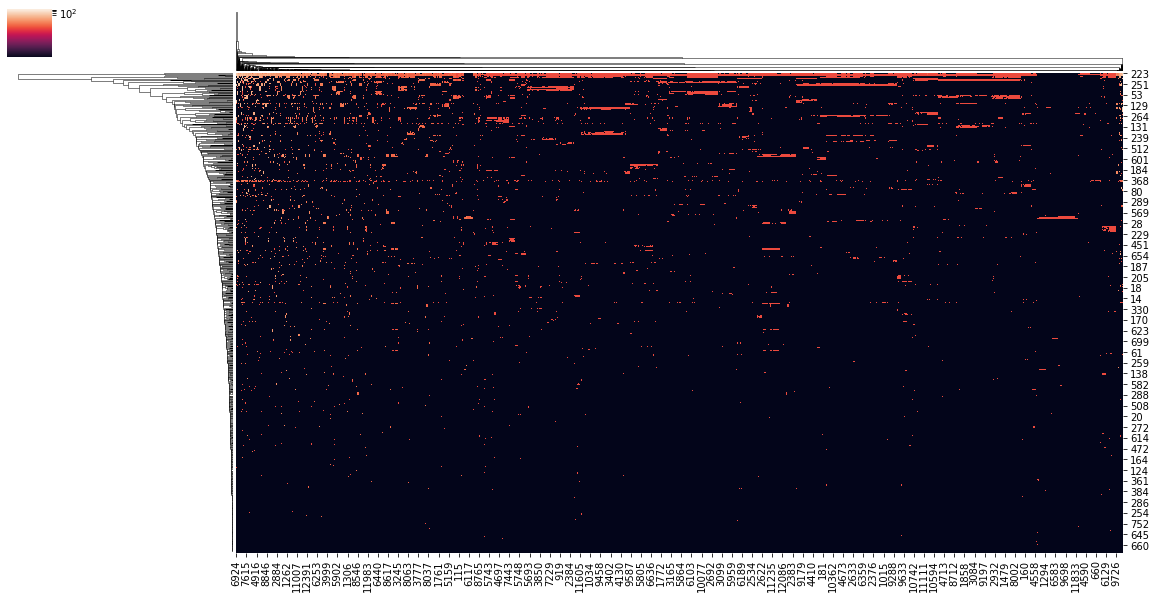

In [30]:
# tag-image heatmap

from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from scipy.sparse import coo_matrix

all_tags = list(x.sql.execute('select * from tags')['tag'])
n_tags = len(all_tags)
all_images = list(x.sql.execute('select * from images')['image'])
n_imgs = len(all_images)

sim = x.sql.execute('select * from tag_image_sim').copy()
sim.tag = sim.tag.map(lambda tag: all_tags.index(tag))
sim.image = sim.image.map(lambda img: all_images.index(img))

tmp = coo_matrix((sim.value, (sim.tag, sim.image)), shape=(n_tags, n_imgs)).toarray()
print('Plotting')
sns.clustermap(tmp + 0.0001, norm=LogNorm(), figsize=(20, 10))

# Todo: discard rows with < 1% usage?

In [ ]:
# image-image heatmap

from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

all_images = list(x.sql.execute('select * from images')['image'])
n_imgs = len(all_images)
sim = x.sql.execute('select * from image_sim').copy()
sim.image_a = sim.image_a.map(lambda img: all_images.index(img))
sim.image_b = sim.image_b.map(lambda img: all_images.index(img))


from scipy.sparse import coo_matrix

tmp = coo_matrix((sim.value, (sim.image_a, sim.image_b)), shape=(n_imgs, n_imgs)).toarray()
tmp = Helpers.mirror_matrix(tmp)

sns.clustermap(tmp + 1,norm=LogNorm())

In [ ]:
# https://stackoverflow.com/questions/71154948/how-can-i-create-network-graph-from-dataframe

import networkx as nx
G = nx.from_numpy_matrix(tmp)
nx.draw_spring(G)

In [ ]:
from gensim.models import doc2vec
from scipy import spatial

d2v_model = doc2vec.Doc2Vec.load(model_file)

fisrt_text = '..'
second_text = '..'

vec1 = d2v_model.infer_vector(fisrt_text.split())
vec2 = d2v_model.infer_vector(second_text.split())

cos_distance = spatial.distance.cosine(vec1, vec2)
# cos_distance indicates how much the two texts differ from each other:
# higher values mean more distant (i.e. different) texts